This tutorial illustrates how to fit EIS data using the conventional DRT, the probability function of relaxation times (PFRT), and the dual regression-classification inversion algorithm. All of the fitting methods are accessed through the `DRT` class.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

from hybdrt.models import DRT
from hybdrt.models import elements
import hybdrt.plotting as hplt

%load_ext autoreload
%autoreload 2

# Simulate data
First, let's simulate some noisy data from an equivalent circuit analog consisting of 3 Havriliak-Negami (HN) elements in series with an ohmic resistance and inductance. The exact DRT of the circuit has two strongly overlapping peaks at $10^{-2}$ s and $10^{-1}$ s. In addition, the data is simulated with a substantial amount of noise, making separation of the two peaks very challenging.

In [3]:
# Noise generation
# --------------------------
def generate_noise(z_exact, rp, sigma_rel, structure, seed, uniform_frac=0.1):
    """
    Generate noise and error structure given exact impedance
    """
    rng = np.random.default_rng(seed)
    
    if structure == 'uniform':
        sigma_z = np.ones(len(z_exact)) * sigma_rel * rp * (1 + 1j)
    elif structure == 'modulus':
        z_mod = np.sqrt(np.real(z_exact * z_exact.conjugate()))
        sigma_z = sigma_rel * rp * z_mod * (1 + 1j) / np.mean(z_mod)
    elif structure == 'mixed':
        z_mod = np.sqrt(np.real(z_exact * z_exact.conjugate()))
        sigma_z = uniform_frac * sigma_rel * rp * (1 + 1j) 
        sigma_z += (1 - uniform_frac) * sigma_rel * rp * z_mod * (1 + 1j) / np.mean(z_mod)
        
    z_err = rng.normal(0, sigma_z.real) + 1j * rng.normal(0, sigma_z.imag)
    
    return sigma_z, z_err

def generate_noisy_data(f, model, sigma_rel, structure, seed, uniform_frac=0.1):
    """
    Generate noisy data from a model
    """
    z_exact = model.predict_z(f)
    rp = model.predict_r_p()
    sigma_z, z_err = generate_noise(z_exact, rp, sigma_rel, structure, seed, uniform_frac)
    
    return z_exact + z_err, sigma_z

<IPython.core.display.Javascript object>


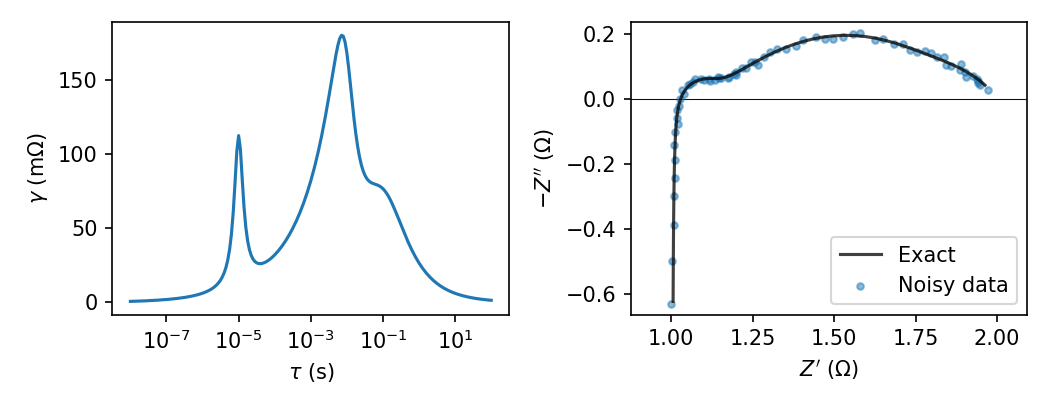

<AxesSubplot:xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>

In [101]:
# Define model
# 3-HN
model = elements.DiscreteElementModel('R0-L0-HN1-HN2-HN3')
model_params = np.array(
    [
        1, np.log(1e-7),  # R0, L0
        0.1, np.log(1e-5), 1, 0.9,  # HN1
        0.6, np.log(1e-2), 0.5, 0.8,  # HN2
        0.3, np.log(1e-1), 1, 0.6  # HN3
    ]
)
model.parameter_values = model_params

# Simulate data
freq = np.logspace(6, -1, 71)
z_true = model.predict_z(freq)
rng = np.random.default_rng(834)
for i in range(4):  # iterate to match seed used for paper
    z_noisy, sigma_z = generate_noisy_data(freq, info['model'], 5e-3, 'mixed', rng.integers(int(1e6)))
    
    
fig, axes = plt.subplots(1, 2, figsize=(7, 2.75))

# Plot exact DRT
tau_plot = np.logspace(-8, 2, 201)
model.plot_distribution(tau_plot, ax=axes[0])

# Plot exact impedance
hplt.plot_nyquist((freq, z_true), plot_func='plot', c='k', label='Exact', alpha=0.75, ax=axes[1])

# Plot noisy data
hplt.plot_nyquist((freq, z_noisy), label='Noisy data', ax=axes[1])

# Baseline DRT fit
We can first fit the noisy data with a conventional DRT algorithm. The baseline DRT algorithm provided by `hybrid-drt` (`DRT.fit_eis`) uses an efficient, self-tuning hierarchical Bayesian model that is effective for recovering a variety of peak shapes while suppressing false peaks.

Note that by default, when a `DRT` instance is created, it will generate a set of interpolation grids that allow the matrices required for inversion to be calculated nearly instantaneously. Generating the grids takes only a second or two, and they can be re-used for all later fits performed with the same instance. To disable this behavior, you can specify `interpolate_integrals=False` at instantiation to force numerical evaluation of the matrices (but this is virtually always slower).

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


<IPython.core.display.Javascript object>


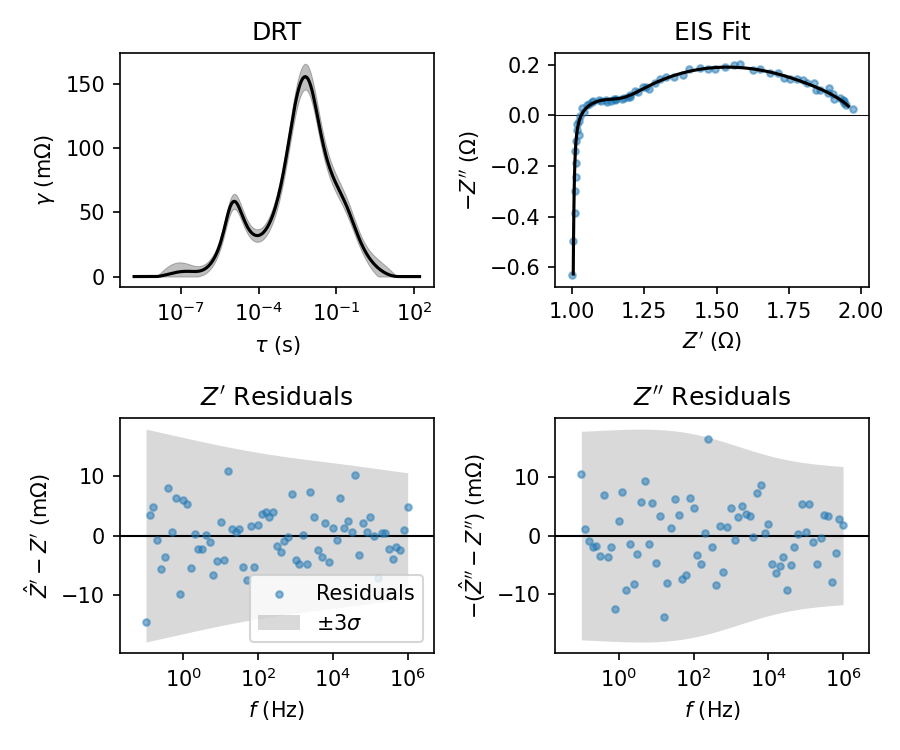

array([[<AxesSubplot:title={'center':'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ (m$\\Omega$)'>,
        <AxesSubplot:title={'center':'EIS Fit'}, xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>],
       [<AxesSubplot:title={'center':'$Z^\\prime$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$\\hat{Z}^{\\prime}-Z^{\\prime}$ (m$\\Omega$)'>,
        <AxesSubplot:title={'center':'$Z^{\\prime\\prime}$ Residuals'}, xlabel='$f$ (Hz)', ylabel='$-(\\hat{Z}^{\\prime\\prime}-Z^{\\prime\\prime})$ (m$\\Omega$)'>]],
      dtype=object)

In [102]:
# Create a DRT instance
drt = DRT()

# Fit the data
drt.fit_eis(freq, z_noisy)

# Plot the results
drt.plot_results()

The `plot_results` method shows a summary set of diagnostic plots. The top left panel shows the estimated DRT with the 95% credible interval, the top right panel shows a Nyquist plot of the fit of the data, and the two bottom panels show the real and imaginary residuals with the estimated error structure of the data overlaid. The DRT estimate indicates that at least two peaks at $10^{-3}$ and $10^{-2}$ are present, but it is very difficult to tell if the shoulder peaks at $10^{-7}$ s and $10^{-1}$ s are real, distinct peaks. This is the inherent ambiguity of analyzing DRT results: we can't tell with certainty which peaks are real and which are erroneous (i.e. induced by noise or the regularization scheme).

Comparing the baseline DRT estimate to the exact DRT (corresponding to the equivalent circuit from which the data were simulated), we find that the baseline estimate matches the true DRT reasonably well. However, using local minima in the curvature to identify peaks in the estimated DRT suggests an erroneous peak at $10^{-7}$ s, while the real peak at $10^{-1}$ s is not clearly resolved.

<IPython.core.display.Javascript object>


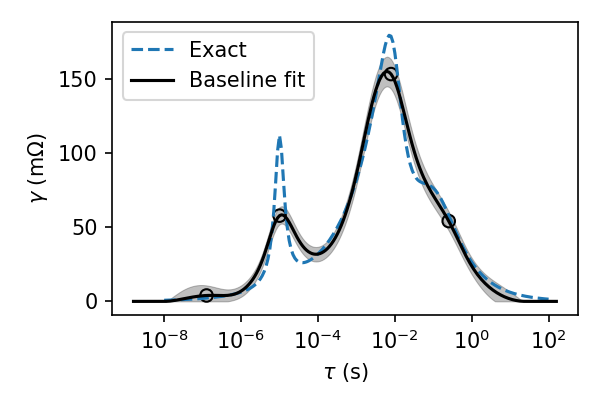

In [103]:
fig, ax = plt.subplots(figsize=(4, 2.75))

model.plot_distribution(tau_plot, ax=ax, label='Exact', ls='--')

drt.plot_distribution(ax=ax, c='k', plot_ci=True, label='Baseline fit', 
                      mark_peaks=True, 
                      mark_peaks_kw={'edgecolors': 'k', 'facecolors': 'none'})

ax.legend()

# Probability function of relaxation times (PFRT) fit
The PFRT is designed to complement the DRT and clarify its interpretation. The PFRT is the classification-centric analog of the DRT: whereas the DRT estimates the magnitude of the distribution as a function of $\ln{\tau}$ (regression), the PFRT estimates the *probabiliity that a peak exists in the DRT* at each $\ln{\tau}$. We can apply the PFRT to the same dataset.

In [104]:
# Copy the DRT object to re-use the integral lookups
drt_pf = deepcopy(drt)

# Perform a PFRT fit
drt_pf.pfrt_fit_eis(freq, z_noisy)

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:1770: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


<IPython.core.display.Javascript object>


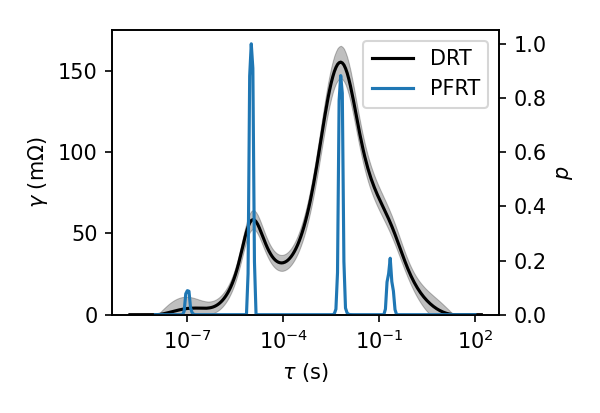

In [105]:
# Calculate the PFRT from the fit results
pf = drt_pf.predict_pfrt(tau_plot)

fig, ax = plt.subplots(figsize=(4, 2.75))
# Plot the PFRT against the baseline DRT
ax, lines = drt.plot_distribution(c='k', plot_ci=True, label='DRT', return_line=True, ax=ax)
ax2 = ax.twinx()
ln2 = ax2.plot(tau_plot, pf, label='PFRT')

ax.set_ylim(0, 175)
ax2.set_ylim(0, 1.05)
ax2.set_ylabel('$p$')

ax.legend(handles=[lines[0][0], ln2[0]], labels=['DRT', 'PFRT'])


fig = ax.get_figure()
fig.tight_layout()

The PFRT tells us that the two primary peaks in the DRT are certain to exist, but indicates relatively weak evidence for the peak at $10^{-1}$ s, while the peak at $10^{-7}$ s is most likely erroneous. However, the PFRT (as currently implemented) is a semi-quantitative tool - it provides a ranking of the plausibilities of different peaks, but may not accurately quantify the evidence for existence of any given peak. This is because the PFRT calculation still relies on continuous DRT estimates that are inherently biased by smoothing regularization. To release this constraint, we must consider discrete models for the data using the dual inversion algorithm.

# Dual regression-classification inversion

The dual regression-classification inversion algorithm uses both continuous (conventional DRT) models and discrete (equivalent circuit) models to analyze the data. Briefly, the dual algorithm uses many DRT fits to generate a set of candidate discrete models for the data, and then evaluates the plausibility of each discrete model. In this way, we can (a) consider several different discrete models, each of which represents a different interpretation of the data, and (b) use rigorous statistical criteria to evaluate and select an appropriate model or models. Currently, discrete models are constructed using HN elements for their versatility, but other elements can be employed.

In [119]:
# Make a copy of the instance to re-use integral lookups
dual = deepcopy(drt)

# Perform a dual fit
dual.dual_fit_eis(freq, z_noisy, discrete_kw=dict(prior=True, prior_strength=None))

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:1770: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\elements.py:981: UserWarning: Determinant of precision matrix is negative. This may indicate a suboptimal solution. Check the fit and LML
  warnings.warn('Determinant of precision matrix is negative. This may indicate a suboptimal '


fill_index: []
rss factor: 0.2565421109878176
prior_strength: 0.817528360107699
rss factor: 0.7009648631416538
prior_strength: 2.2337800716254606
rss factor: 0.8986202499362197
prior_strength: 2.8636528188731343
rss factor: 0.982481423948578
prior_strength: 3.130895057595826
rss factor: 1.0198549218761117
prior_strength: 3.249994001447723
rss factor: 1.0384131075299263
prior_strength: 3.3091337778599383
rss factor: 1.0306136938063184
prior_strength: 3.2842792154385454


The dual algorithm generates a set of discrete candidates. These candidates are summarized in the `discrete_candidate_df` DataFrame, which lists candidates by the number of discrete elements (peaks) that they contain. The plausibility of the candidates is evaluated by three different criteria: the Bayesian information criterion (BIC), the approximate log-marginal-likelihood (LML), and a combination of both (LML-BIC). Smaller BIC values indicate greater plausibility, while higher LML values indicate greater plausibility. The `rel_<criterion>` columns indicate criteria values relative to the best value for each criterion, such that the most plausible candidate as determined by each criterion will have a `rel_<criterion>` value of zero. In the DataFrame shown below, the BIC and LML-BIC indicate that the 3-peak model is most plausible, while the LML suggests that the 2- and 3-peak models are both highly plausible.

In [122]:
dual.discrete_candidate_df

,model_id,num_peaks,llh,bic,lml,lml-bic,rel_llh,rel_bic,rel_lml,rel_lml-bic
0,2.0,2.0,672.861034,-1303.095269,616.700241,634.123938,-20.123990,5.796125,0.000000,-1.395671
1,3.0,3.0,684.284456,-1308.891394,616.593520,635.519609,-8.700568,0.000000,-0.106721,0.000000
2,4.0,4.0,686.216496,-1295.704755,605.238826,626.545602,-6.768528,13.186640,-11.461414,-8.974007
3,5.0,5.0,688.230400,-1282.681843,592.015164,616.678043,-4.754624,26.209551,-24.685076,-18.841566
4,6.0,6.0,691.202076,-1271.574476,583.830769,609.809003,-1.782947,37.316918,-32.869472,-25.710605
5,7.0,7.0,692.821231,-1257.762067,574.004544,601.442788,-0.163792,51.129328,-42.695697,-34.076820
6,8.0,8.0,692.985024,-1241.038932,560.936825,590.728145,0.000000,67.852462,-55.763416,-44.791463


The model plausibilities may also be visualized with the `plot_norm_bayes_factors` method, which plots the normalized Bayes factor ($B_Q$) as a function of the number of model peaks ($Q$). The $B_Q$ value is a direct quantification of plausibility: the most plausible model receives a value of 1, and all other models are quantified relative to that model.

<IPython.core.display.Javascript object>


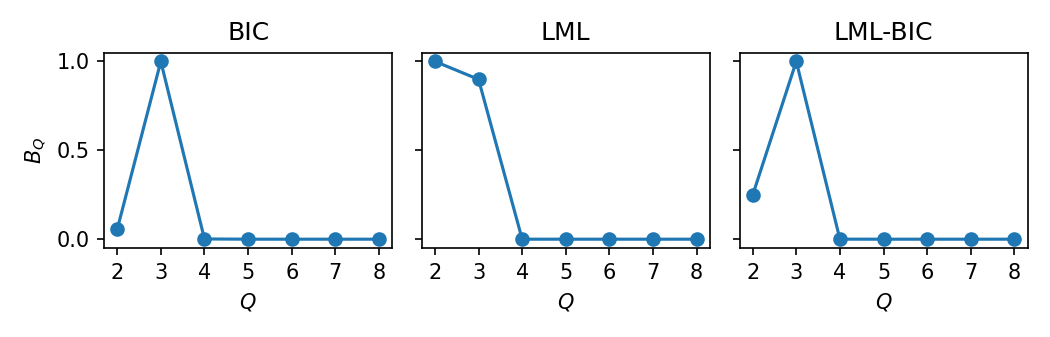

In [123]:
# Plot normalized Bayes factors for each model
fig, axes = plt.subplots(1, 3, figsize=(7, 2.25), sharex=True, sharey=True)
for i, crit in enumerate(['bic', 'lml', 'lml-bic']):
    dual.plot_norm_bayes_factors('discrete', criterion=crit, marker='o', ax=axes[i])
    axes[i].set_title(crit.upper())
    
    if i > 0:
        axes[i].set_ylabel('')
        
fig.tight_layout()

If we plot the three most plausible discrete candidates identified by the algorithm ($2 \leq Q \leq 4$), we see that they correspond well to both the DRT and the PFRT. The two-peak model captures the two clearly resolved peaks, the three-peak model captures all three real peaks, and the four-peak model adds the pseudo-peak at $10^{-7}$ s. The model selection criteria above tell us that the three-peak model is the most plausible model; the two-peak model is not entirely unreasonable, but the four-peak model is strongly rejected. 

<IPython.core.display.Javascript object>


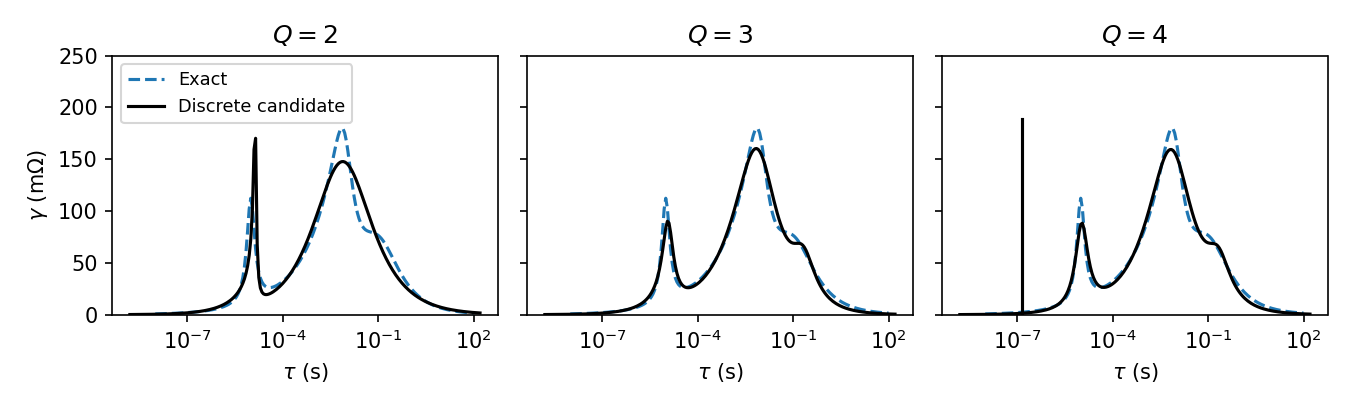

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.75), sharex=True, sharey=True)

for i, q in enumerate([2, 3, 4]):
    ax = axes[i]
    
    # Plot true DRT
    model.plot_distribution(tau_plot, ax=ax, ls='--', label='Exact')
    
    # Plot discrete model DRT
    dual.plot_candidate_distribution(q, 'discrete', c='k', ax=ax, label='Discrete candidate')
    
    if i > 0:
        ax.set_ylabel('')
        
    ax.set_title(f'$Q={q}$')
        
axes[0].set_ylim(0, 250)
axes[0].legend(loc='upper left', fontsize=8.5)
        
fig.tight_layout()

The most plausible 3-peak model matches the true DRT very closely and identifies all three peak locations accurately. Thus, with this approach, we're able to very quickly identify and optimize possible models, select the most appropriate models, and quantify uncertainty in model selection and peak existence.